# Modifying metadata

In this example we will show how to modify the metadata of a SDFITS file using `dysh`.

## Background

We will use a practical example. For observations with the GBT it is recommended to observe a flux density calibrator (see e.g., [Perley & Buttler 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..230....7P/abstract) for a list of calibrator sources and their flux densities) with the same configuration as that used for the science observations. The reason being that the values of the temperature equivalent power of the noise diodes stored in the SDFITS files can be out of date.

In this example we won't use observations of a flux density calibrator, but instead we will use the analysis of [Goddy et al (2020)](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4....3G/abstract). They find that the temperature stored in the SDFITS files is on average lower than the measured values, so that the temperature must be corrected by 20%
$$T_{\rm{CAL,corr}}=1.2T_{\rm{CAL,file}}.$$
Here we use this to correct the temperature of the noise diode.

## Example

We start by importing the relevant modules.

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad

### Data retrieval

We download the data we will use for this example, if necessary.

In [2]:
filename = "AGBT05B_047_01.raw.acs.fits"
filename_saved = f"data/{filename}"
if not os.path.isfile(filename_saved):
    url = f"http://www.gb.nrao.edu/dysh/example_data/positionswitched/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename_saved)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded at {filename_saved}")

AGBT05B_047_01.raw.acs.fits already downloaded


### Data loading

We load the data and inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename_saved)

In [4]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


### Metadata inspection

Now we inspect the current noise diode temperature stored in the SDFITS file.

In [5]:
sdfits["TCAL", "PLNUM"]

,TCAL,PLNUM
0,1.424292,1
1,1.424292,1
2,1.452650,0
3,1.452650,0
4,1.424292,1
...,...,...
347,1.452650,0
348,1.424292,1
349,1.424292,1
350,1.452650,0


For polarization 0 the noise diode temperature is 1.452650 K and for polarization 1 it is 1.424292 K.

We will calibrate the data using these values to compare after we update the noise diode temperature. We use position switching calibration, then we time average all the scans and remove an order 1 polynomial.

In [6]:
ps_original = sdfits.getps(plnum=0).timeaverage()
ps_original.baseline(degree=1, remove=True)

EXCLUDING None


### Metadata update

Now we update the temperature of the noise diode by multiplying by 1.2.

In [7]:
sdfits["TCAL"] *= 1.2

/home/sandboxes/psalas/Dysh/dysh/src/dysh/fits/gbtfitsload.py:1882: UserWarning: Changing an existing SDFITS column
  warnings.warn("Changing an existing SDFITS column")
/home/sandboxes/psalas/Dysh/dysh/src/dysh/fits/sdfitsload.py:929: UserWarning: Changing an existing SDFITS column
  warnings.warn("Changing an existing SDFITS column")


Now we check that the values were updated.

In [8]:
sdfits["TCAL", "PLNUM"]

,TCAL,PLNUM
0,1.70915,1
1,1.70915,1
2,1.74318,0
3,1.74318,0
4,1.70915,1
...,...,...
347,1.74318,0
348,1.70915,1
349,1.70915,1
350,1.74318,0


The values were updated. We proceed with the data reduction.

In [9]:
ps_updated = sdfits.getps(plnum=0).timeaverage()
ps_updated.baseline(degree=1, remove=True)

EXCLUDING None


Now plot and compare the result. Since the antenna temperature is directly proportional to the temperature of the noise diode, now the line profile after the update should be 20% brighter than without the update.

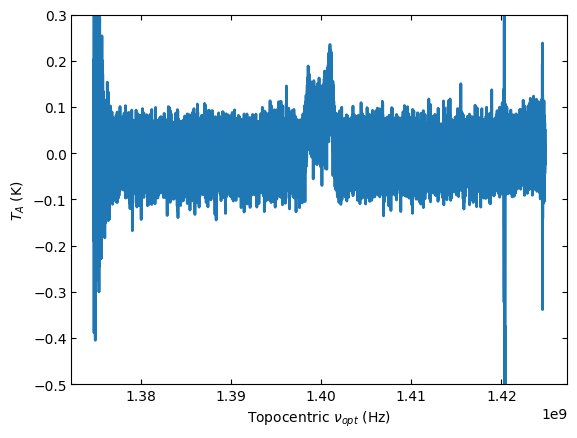

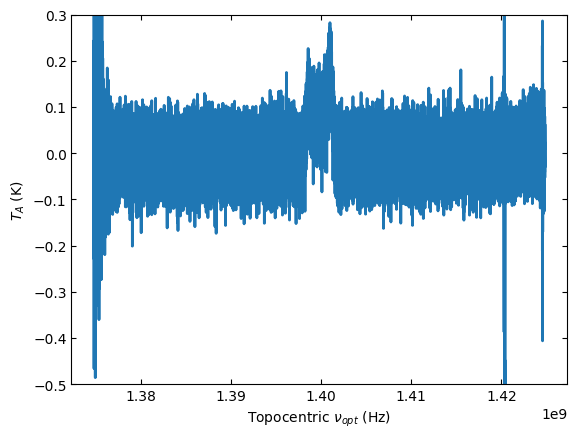

In [11]:
ps_original.plot(ymin=-0.5, ymax=0.3)
ps_updated.plot(ymin=-0.5, ymax=0.3)